[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/network-in-network/blob/master/nin.ipynb)

In [2]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 519.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x592ea000 @  0x7f1cad3701c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 3.5MB/s 
    100% |████████████████████████████████| 2.0MB 9.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torchvision
from torch import nn,optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [60]:
transform=transforms.Compose([transforms.ToTensor()])
trainset=datasets.CIFAR10(root='drive/app/fashion',train=True,download=True,transform=transform)
testset=datasets.CIFAR10(root='drive/app/fashion',train=False,download=True,transform=transform)
trainloader=DataLoader(trainset,batch_size=64,num_workers=4,shuffle=True)
testloader=DataLoader(testset,batch_size=64,num_workers=4,shuffle=True)
sizeoftrainset=len(trainset)
sizeoftestset=len(testset)
classes = np.array(('airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck'))


Files already downloaded and verified
Files already downloaded and verified


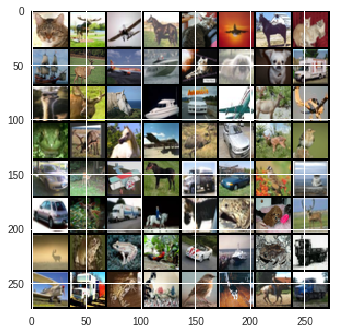

In [68]:
a=iter(trainloader)
def show(image):
  untransform=transforms.ToPILImage()
  plt.figure()
  plt.imshow(untransform(image))
  plt.show()
  
show(torchvision.utils.make_grid(a.next()[0]))

torch.cuda.empty_cache()

In [0]:
class nin(nn.Module):
  def __init__(self):
    super(nin,self).__init__()
    self.layer1=nn.Sequential(
               nn.Conv2d(3,96,5),
               nn.ReLU(inplace=True),
               nn.Conv2d(96,96,1),
               nn.ReLU(inplace=True),
               nn.Conv2d(96,96,1),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(3,stride=2),
               nn.Dropout(0.3))
    self.layer2=nn.Sequential(
               nn.Conv2d(96,192,5),
               nn.ReLU(inplace=True),
               nn.Conv2d(192,192,1),
               nn.ReLU(inplace=True),
               nn.Conv2d(192,192,1),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(3,stride=2),
               nn.Dropout(0.3))
    self.layer3=nn.Sequential(
               nn.Conv2d(192,192,3),
               nn.ReLU(inplace=True),
               nn.Conv2d(192,192,1),
               nn.ReLU(inplace=True),
               nn.Conv2d(192,10,1),
               nn.ReLU(inplace=True),
               nn.AvgPool2d(2,stride=1))
    
    
  def forward(self,x):
   
    x=self.layer1(x)
    x=self.layer2(x)
    output=self.layer3(x)
    return output.view(output.size()[0],-1)
  
nin=nin()


In [66]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(nin.parameters(),lr=0.01)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.1)
num_epoch=100
Losslist=[]
def train():
  
  for i in range(num_epoch):
    running_loss=0
    for image,labels in trainloader:
       image.type(torch.cuda.FloatTensor)
       image.cuda()
       labels.type(torch.cuda.LongTensor)
       labels.cuda()
       nin.zero_grad()
       out=nin(image)
       loss=criterion(out,labels)
       running_loss+=loss
       loss.backward()
       optimizer.step()
    scheduler.step()
    lossofepoch=running_loss/sizeoftrainset
    Losslist.append(running_loss/sizeoftrainset)
    print('running_loss{}:{}'.format(i,lossofepoch))
   
  
  
  
train()

RuntimeError: ignored

In [0]:
plt.figure()
plt.plot(Losslist)
plt.show()

In [0]:
class_total=np.zeros(10,)
class_correct=np.zeros(10,)

correctsum=0
for i in testloader:
   image,label=i
   label=label.type(dtype)
   image.to(device)
   label.to(device)
   output=net(image)
   predict=torch.max(output,1)[1]
   labels=label.cpu().numpy()
   predicts=predict.cpu().numpy()
   unique_elements, counts_elements = np.unique(labels, return_counts=True)
   class_total[unique_elements]+=counts_elements
   correct=(predicts==labels)
   c=[predicts[m] for m,n in enumerate(correct) if n==1]
   uts, cts = np.unique(c, return_counts=True)
   class_correct[uts]+=cts
   correctsum+=correct.sum()
   
print('class accuracy percentage:',class_correct/class_total*100,'\ntotal accuracy:',correctsum/sizeoftestset*100)
